In [1]:
import pickle
file_path='models/car_svm.pkl'
f=open(file_path, 'rb')
svm = pickle.load(f)

In [2]:
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib 
import cv2
import matplotlib.pyplot as plt
from mns import nms,sliding_window
import numpy as np
import os
%matplotlib inline

In [3]:
# path='data/Test/TestImages'
path='data/Test/Test1'
image_heigh = 40
image_width = 100
def read_images(path):
    images = []
    gray_images = []
    file_names = []
    dirs = os.listdir(path )
    for file in dirs:
        file_name=path+"/"+file
        image = cv2.imread(file_name)
        gray_image = imread(file_name, as_grey=False)
#         image = cv2.resize(image, (image_width, image_heigh))
#         gray_image = cv2.resize(gray_image, (image_width, image_heigh))
        images.append(image)
        gray_images.append(gray_image)
        file_names.append(file.split('.')[0])
    return np.asarray(images), np.asarray(gray_images), file_names

images, gray_images, file_names=read_images(path)

In [4]:
scale = 0
downscale=1.25
min_wdw_sz = (100, 40)
step_size = (10, 10)

detections = []
for index, im in enumerate(gray_images):
    detected_areas = []
    for im_scaled in pyramid_gaussian(im, downscale=downscale):
        cd = []
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue

            fd=hog(im_window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=False)
            fd = fd.reshape(1,-1)
            pred = svm.predict(fd)
            if pred == 1:
                detected_areas.append((x, y, svm.decision_function(fd),
                    int(min_wdw_sz[0]*(downscale**scale)),
                    int(min_wdw_sz[1]*(downscale**scale))))
                cd.append(detected_areas[-1])
        scale+=1
    detections.append(detected_areas)   


/home/james/virt3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [5]:
# path="data/CarData/TestImages_Scale/test-52.pgm"
# path="data/Test/TestImages/test-0.pgm"

# im1=cv2.imread(path)
# im = imread(path, as_grey=False)
# scale = 0
# downscale=1.25
# min_wdw_sz = (100, 40)
# step_size = (10, 10)

# detections = []
# for im_scaled in pyramid_gaussian(im, downscale=downscale):
#     cd = []
#     if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
#         break
#     for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
#         if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
#             continue
   
#         fd=hog(im_window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=False)
#         fd = fd.reshape(1,-1)
#         pred = svm.predict(fd)
#         if pred == 1:
# #             print("detection location")
#             detections.append((x, y, svm.decision_function(fd),
#                 int(min_wdw_sz[0]*(downscale**scale)),
#                 int(min_wdw_sz[1]*(downscale**scale))))
#             cd.append(detections[-1])
#     scale+=1

In [6]:
from datetime import datetime

def get_file_name(path):
    test_file_name_array = path.split('/')
    test_file_name_array = test_file_name_array[len(test_file_name_array)-1].split('.')
    test_file = test_file_name_array[0]

    return test_file
# test_file = get_file_name(path)

In [7]:
print (len(detections))
print (detections)
print (len(detections[0]) == 0)
print (len(detections[1]) == 0)

2
[[(70, 100, array([ 0.01346169]), 125, 50)], [(110, 40, array([ 0.3392543]), 305, 122), (120, 40, array([ 0.76496681]), 305, 122), (130, 40, array([ 0.89849565]), 305, 122), (120, 70, array([ 0.20298719]), 305, 122), (130, 70, array([ 0.05372346]), 305, 122), (80, 80, array([ 0.37800662]), 305, 122), (90, 80, array([ 0.1105537]), 305, 122), (100, 80, array([ 0.62263376]), 305, 122), (110, 80, array([ 0.29418818]), 305, 122), (130, 80, array([ 0.35655775]), 305, 122), (140, 80, array([ 1.01003262]), 305, 122), (150, 80, array([ 0.01060606]), 305, 122), (60, 90, array([ 0.3812056]), 305, 122), (70, 90, array([ 0.08907578]), 305, 122), (160, 90, array([ 0.15591456]), 305, 122), (30, 100, array([ 0.0564041]), 305, 122), (40, 100, array([ 0.24021707]), 305, 122), (20, 10, array([ 0.0075797]), 381, 152), (70, 20, array([ 0.9105596]), 381, 152), (80, 20, array([ 0.97861505]), 381, 152), (90, 20, array([ 1.0768674]), 381, 152), (80, 50, array([ 0.42680639]), 381, 152), (90, 50, array([ 0.383

In [8]:
from datetime import datetime
import matplotlib
#extract detections area into images
croped_images = []
saved_folder = 'data/Car/temp'
def save_file(file_name, index, image):
    filename = "{}/{}-{}-{}.png".format(saved_folder,file_name, index, datetime.utcnow().strftime("%Y%m%d%H%M%S"))
#     plt.imshow(image)
#     plt.savefig(filename)
    matplotlib.image.imsave(filename, image)

for index, detection in enumerate(detections):
    for idx, (x_tl, y_tl, _, w, h) in enumerate(detection):
        image = images[index][y_tl:y_tl+h, x_tl:x_tl+w]
        image = cv2.resize(image, (image_width, image_heigh))
        file_name = file_names[index]
        croped_images.append(image)
        save_file(file_name, idx, image)

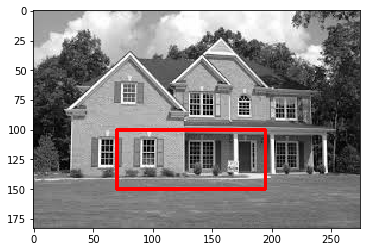

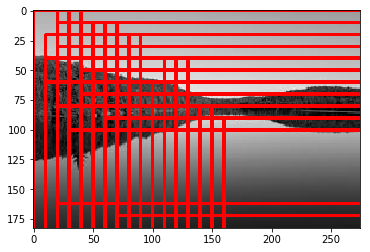

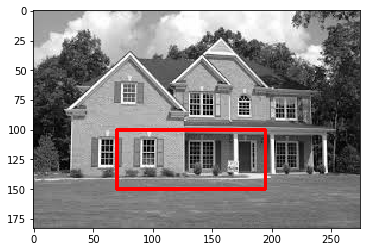

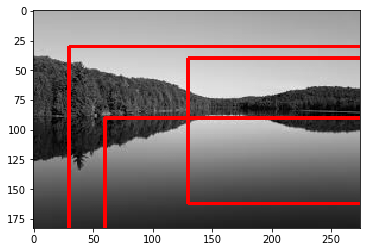

In [9]:
clone_images = images[0:2].copy()
detections = detections[0:2]

for index, detection in enumerate(detections):
    image = images[index]
    for (x_tl, y_tl, _, w, h) in detection:
        cv2.rectangle(image, (x_tl, y_tl), (x_tl+w, y_tl+h), (0, 0, 255), thickness=2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

threshold=.3
for index, detection in enumerate(detections):
    clone = clone_images[index]
    new_detection = nms(detection, threshold)
    for (x_tl, y_tl, _, w, h) in new_detection:
        cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 255), thickness=2)
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))


    plt.show()